# Route Inspection Problem
### (Chinese Postman Problem)

> To find the shortest closed path which visits every edge of a (connected) undirected graph.

### Conceptual Solution

A **Eulerian circuit** should exist in the graph: a closed-circuit path which visits every edge *exactly once*.

If such a circuit does not exist, generate that condition from the given graph: 

>Find the minimal set of the graph's edges to duplicate such that the resulting multigraph **does** have a Eulerian circuit.

The subset of edges must have the minimum possible total weight, or if edge weight is a non-factor, the smallest number of edges.

### Algorithm (generalised)

1. Find all nodes with an odd [degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)).

2. Add edges to the graph such that odd-degree nodes become even-degree (accounts for and minimises backtracking): 
   
> any edges added must be duplicates of graph's original edges
    
> the added set of edges must have minimal total weight (np-hard)
    
3. Find the Eulerian circuit in the regenerated multigraph.

----

### Data Preparation

Gather dependencies:

In [9]:
# stdlib dependencies
import itertools
import copy

# external libraries
import networkx as nx
import pandas   as pd
import matplotlib.pyplot as pltEuler circuit

Obtain external data:

> We use a dataset that maps connections/intersections between various hiking trails in Sleeping Giant Provincial Park (Ontario, Canada).

In [15]:
import io
import requests as r

NODE_CSV = 'https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv'
EDGE_CSV = 'https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv'

nodes = pd.read_csv(io.StringIO(r.get(NODE_CSV).content.decode('utf-8')))
edges = pd.read_csv(io.StringIO(r.get(EDGE_CSV).content.decode('utf-8')))

Previewing data:

In [20]:
nodes

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771
...,...,...,...
72,y_gy2,1939,1182
73,y_rc,1429,1491
74,y_rh,717,1852
75,y_rs,1805,1246


In [21]:
edges

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
...,...,...,...,...,...,...
118,v_bv,b_bv,bv,0.08,purple,0
119,g_gy2,w_gy2,gy2,0.05,yellowgreen,0
120,w_gy2,b_gy2,gy2,0.03,yellowgreen,1
121,b_gy2,o_gy2,gy2,0.07,yellowgreen,0


----

### Graph Creation

Begin by generating an empty graph:

In [34]:
g = nx.Graph()

Add edges and hydrate with edge attributes:

In [37]:
for _, row in edges.iterrows():
    g.add_edge(
        row[0],  # from node
        row[1],  # to node
        attr_dict=row[2:].to_dict()
    )

Now hydrate the graph with desired node attributes:

In [74]:
attrs = {
    row['id']: row[1:].to_dict()
    for _, row in nodes.iterrows()
}

nx.set_node_attributes(g, attrs)

In brief, the graph we've ended up with:

In [79]:
g.number_of_nodes(), g.number_of_edges()

(77, 123)

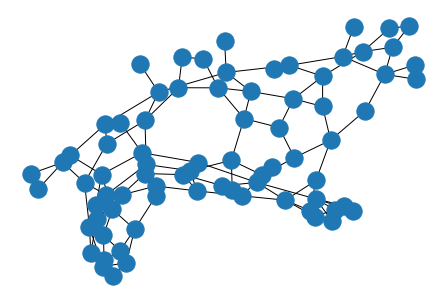

In [80]:
nx.draw(g)

----

### Visualization Prep

To control positional layout, first transcribe a `{node: (x, y), ...}` dictionary:

> `y` is negated so y-origin is at bottom-left, not top-left

In [120]:
node_positions = {
    nd: (g.nodes()[nd]['X'], -g.nodes()[nd]['Y'])
    for nd in g.nodes()
}

To control edge colour, gather that field from the provided data (wherein an edge belonging to a trail has that trail's colour):

In [123]:
edge_attr   = g.edges().values()
edge_colors = [e['attr_dict']['color'] for e in edge_attrs] 

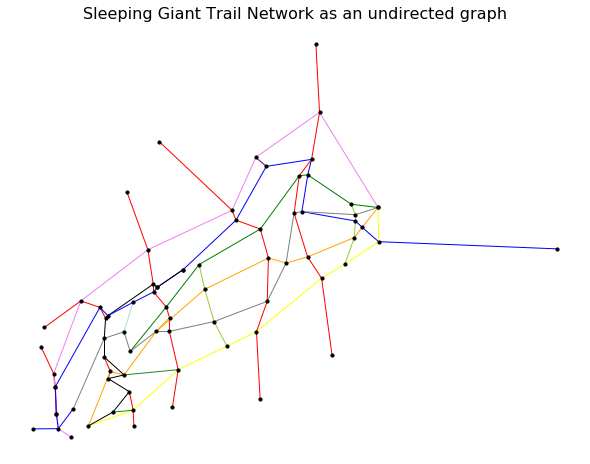

In [128]:
plt.figure(figsize=(8,6))

nx.draw(
    g,
    pos        = node_positions,
    edge_color = edge_colors,
    node_size  = 10,
    node_color = 'black'
)

plt.title('Sleeping Giant Trail Network as an undirected graph', size=16)
plt.show()

----

### Algorithm Implementation

1. Find all nodes with an odd degree.

In [143]:
odd_nodes = [node for node, degree in g.degree() if degree % 2]

f'Of {len(g.nodes())} total nodes, {len(odd_nodes)} have odd degree.'

'Of 77 total nodes, 36 have odd degree.'

----

2. Compute the 'minimum' subset of edges that need to be duplicated to regenerate a graph where a Eulerian circuit can exist.
    
    **a.** Compute all possible pair combinations of odd-degree nodes.
    
    **b.** Compute the shortest path between each node pair in `a`.
    
    **c.** Generate a [complete graph](https://en.wikipedia.org/wiki/Complete_graph) that connects each node pair from `a` with their respective shortest path attributes from `b`.
    
    **d.** Compute the [minimum weight matching](https://en.wikipedia.org/wiki/Matching_(graph_theory)) of `c`'s graph to obtain the minimum subset of the main graph's edges that need to be duplicated to allow a Eulerian circuit.
    
    **e.** "Add" the shortest path series between node pairs calculated in `d` to the main graph.

In [144]:
# 2a: node pairs
odd_node_pairs = list(itertools.combinations(odd_nodes, 2))

In [148]:
# 2b: shortest path between all pairs
weights = {}

for pair in odd_node_pairs:
    weights[pair] = nx.dijkstra_path_length(
        g,
        pair[0], pair[1],
        weight='distance'
    )

In [167]:
# 2c: complete graph of node pairs with shortest path attrs
cg = nx.Graph()

# add context for why we flip weights
for pair, w in weights.items():
        cg.add_edge(
            pair[0], pair[1],
            attr_dict={'distance': w, 'weight': -w}
        )

In [168]:
len(cg.nodes()), len(cg.edges())

(36, 630)

Let's pause and visualize the **complete graph** (fully connected graph) of odd-degree node pairs:

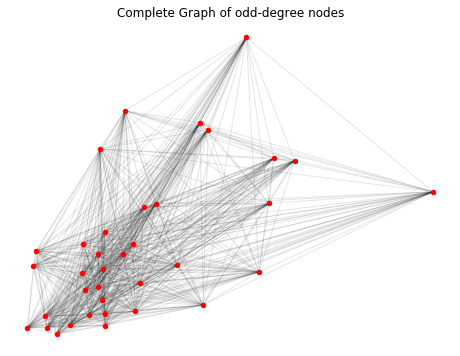

In [175]:
plt.figure(figsize=(8,6))

pos_rand = nx.random_layout(cg)

nx.draw_networkx_nodes(cg, node_positions, node_size=20, node_color='red')
nx.draw_networkx_edges(cg, node_positions, alpha=0.1)

plt.axis('off')
plt.title('Complete Graph of odd-degree nodes')
plt.show()